# Nested samping using Galilean Monte Carlo

This example demonstrates how to use Galilean Monte Carlo sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data. For a tutorial on nested sampling, see: [INSERT LINK to NESTED SAMPLING TUTORIAL NOTEBOOK].

[1] "Exploring Multi-Modal Distributions with Nested Sampling", 2013, Farhan Feroz and John Skilling.

First create fake data.

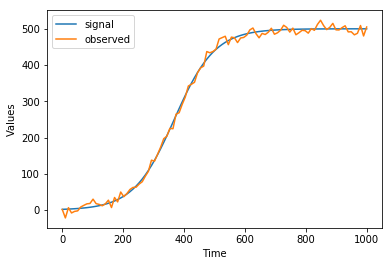

In [1]:
import os
os.chdir('/Users/appleuser/Desktop/AllPints/pints/')
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
r = 0.015
k = 500
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = signal_values + pints.noise.independent(sigma, signal_values.shape)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

Create the nested sampler that will be used to sample from the posterior.

In [ ]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, sigma * 0.5],
    [0.02, 600, sigma * 1.5])

# Create a nested ellipsoidal rejectection sampler
sampler = pints.GalileanMC(log_likelihood, log_prior)

# Set number of iterations
sampler.set_iterations(4000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(400)

# Set the number of active points
sampler.set_n_active_points(1000)

# Set velocity proposal distribution
sampler.set_random_propose(False, mu=[0,0,0], sigma=[[0.005,0,0],[0,10,0],[0,0,0.1]])

Run the sampler!

In [ ]:
samples, marginal_log_likelihood = sampler.run()
print('Done!')

Running Galilean Monte Carlo (nested) sampler
Number of active points: 1000
Total number of iterations: 4000
Total number of posterior samples: 400
Iter. Eval. Time m:s Delta_log(z)
0     1       0:00.0 -inf        
0     2       0:00.0 -inf        
0     3       0:00.0 -inf        
0     4       0:00.0 -inf        
0     5       0:00.0 -inf        
0     21      0:00.0 -inf        
0     41      0:00.0 -inf        
0     61      0:00.0 -inf        
0     81      0:00.0 -inf        
0     101     0:00.0 -inf        
0     121     0:00.1 -inf        
0     141     0:00.1 -inf        
0     161     0:00.1 -inf        
0     181     0:00.1 -inf        
0     201     0:00.1 -inf        
0     221     0:00.1 -inf        
0     241     0:00.1 -inf        
0     261     0:00.1 -inf        
0     281     0:00.1 -inf        
0     301     0:00.1 -inf        
0     321     0:00.1 -inf        
0     341     0:00.1 -inf        
0     361     0:00.2 -inf        
0     381     0:00.2 -inf        
0 

pints/toy/_logistic_model.py:64: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * times)
pints/toy/_logistic_model.py:67: RuntimeWarning: overflow encountered in multiply
  values = k / (1 + c * exp)


1020  1175    0:00.8 -20213.63443
1040  1417    0:01.1 -15410.17476
1060  1637    0:01.4 -13209.52995
1080  2059    0:01.9 -12042.94637
1100  2595    0:02.5 -10003.24885
1120  3081    0:03.0 -9051.177234
1140  4041    0:04.0 -8666.972799


pints/_log_likelihoods.py:154: RuntimeWarning: invalid value encountered in log
  - np.sum(error**2, axis=0) / (2 * sigma**2))


1160  4513    0:04.5 -7978.449169
1180  5129    0:05.1 -7272.759256
1200  6141    0:06.2 -6903.028815
1220  6981    0:07.1 -6455.408139
1240  7693    0:07.8 -6138.389953
1260  8645    0:08.9 -5853.081448
1280  9681    0:09.9 -5623.378228
1300  10443   0:10.6 -5365.857028
1320  11249   0:11.5 -5089.557232
1340  12357   0:12.6 -4860.821722
1360  13841   0:14.1 -4680.615647
1380  15087   0:15.4 -4483.968106
1400  16351   0:16.7 -4350.926298
1420  17667   0:18.1 -4133.734342
1440  18487   0:19.0 -3994.431609
1460  19465   0:19.9 -3818.939404
1480  20745   0:21.3 -3659.322756
1500  22157   0:22.7 -3525.257877
1520  23789   0:24.5 -3423.424791
1540  25009   0:25.7 -3341.039365
1560  26669   0:27.5 -3231.465266
1580  27645   0:28.5 -3132.718321
1600  28871   0:29.9 -3014.194545
1620  30961   0:31.8 -2891.690715
1640  32701   0:33.5 -2750.774748
1660  34399   0:35.2 -2654.071088
1680  36415   0:37.1 -2563.980161
1700  37465   0:38.2 -2497.039907
1720  39177   0:40.0 -2435.0549  
1740  40637   

## Show active and inactive points

In [ ]:
m_active = sampler.active_points()
m_inactive = sampler.inactive_points()

f, axarr = plt.subplots(1,3,figsize=(15,6))
axarr[0].scatter(m_inactive[:,0],m_inactive[:,1])
axarr[0].scatter(m_active[:,0],m_active[:,1],alpha=0.1)
axarr[0].set_xlim([0.008,0.022])
axarr[0].set_xlabel('r')
axarr[0].set_ylabel('k')
axarr[1].scatter(m_inactive[:,0],m_inactive[:,2])
axarr[1].scatter(m_active[:,0],m_active[:,2],alpha=0.1)
axarr[1].set_xlim([0.008,0.022])
axarr[1].set_xlabel('r')
axarr[1].set_ylabel('sigma')
axarr[2].scatter(m_inactive[:,1],m_inactive[:,2])
axarr[2].scatter(m_active[:,1],m_active[:,2],alpha=0.1)
axarr[2].set_xlabel('k')
axarr[2].set_ylabel('sigma')
plt.show()

## Plot posterior samples versus true parameter values (dashed lines)

In [ ]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=[r, k, sigma])

plt.show()

In [ ]:
vTheta = samples[0]
pints.plot.pairwise(samples, kde=True)

plt.show()

## Plot posterior predictive simulations versus the observed data

In [ ]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate

In [ ]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))